# Udacity Dog Project: Transfer Learning and Data Augmentation

The [Udacity Dog Project](https://github.com/udacity/dog-project) provides a labeled image dataset of 133 dog breeds for practicing training CNNs for image classification.  

In this notebook we experiment with transfer learning from the [Xception model](https://keras.io/applications/#xception) pre-trained on Imagenet, and data augmentation using a [keras ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class).

### Data Preparation

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

np.random.seed(37)

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../input/udacitydogproject/dogimages/dogImages/train')
valid_files, valid_targets = load_dataset('../input/udacitydogproject/dogimages/dogImages/valid')
test_files, test_targets = load_dataset('../input/udacitydogproject/dogimages/dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("../input/udacitydogproject/dogimages/dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [3]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')#/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')#/255
# test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 835/835 [00:07<00:00, 114.66it/s]


In [4]:
train_tensors.shape

(6680, 224, 224, 3)

In [5]:
import matplotlib.pyplot as plt
def vis_learning_curve(learning):
    train_loss = learning.history['loss']
    train_acc = learning.history['acc']
    val_loss = learning.history['val_loss']
    val_acc = learning.history['val_acc']

    fig, axes = plt.subplots(1, 2, figsize=(20,4), subplot_kw={'xlabel':'epoch'} )
    axes[0].set_title("Accuracy")
    axes[0].plot(train_acc)
    axes[0].plot(val_acc)
    axes[0].legend(['training','validation'])
    axes[1].set_title("Loss")
    axes[1].plot(train_loss)
    axes[1].plot(val_loss)
    axes[1].legend(['training','validation'])

    best_training_epoc = val_loss.index(np.min(val_loss))
    axes[0].axvline(x=best_training_epoc, color='red')
    axes[1].axvline(x=best_training_epoc, color='red')

### Model definition

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.applications.xception import Xception, preprocess_input
from keras.layers import Flatten, Dropout, Dense, GlobalAveragePooling2D
from keras.models import Sequential

xception_model = Xception(weights='imagenet', include_top=False, input_shape=train_tensors.shape[1:])
for layer in xception_model.layers:
    layer.trainable=False
model = Sequential()
model.add(xception_model)
model.add(Dropout(.3))
model.add(GlobalAveragePooling2D())
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
model.add(Dense(133, activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 2048)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               272517    
Total params: 21,133,997
Trainable params: 272,517
Non-trainable params: 20,861,480
_________________________________________________________________


### Data Augmentation and Training

In [7]:
from keras.callbacks import ModelCheckpoint

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
train_datagen = ImageDataGenerator(
#         height_shift_range=20,  width_shift_range=20, 
        shear_range=20, 
        rotation_range=20,
        horizontal_flip=True,
        preprocessing_function=preprocess_input,
    ).flow(train_tensors, y=train_targets, seed=37, batch_size=20)

valid_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    ).flow(valid_tensors, y=valid_targets, batch_size=20)

checkpointer = ModelCheckpoint(filepath='weights.best.Xception_with_data_augmentation.hdf5', 
                               verbose=1, save_best_only=True)

training = model.fit_generator(
    train_datagen, 
    validation_data=valid_datagen,
    epochs=20, 
    steps_per_epoch=np.ceil(len(train_datagen.y)/train_datagen.batch_size),
    validation_steps=np.ceil(len(valid_datagen.y)/valid_datagen.batch_size),
    callbacks=[checkpointer], 
#     workers=4,
#     use_multiprocessing=True,
    verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
334/334 [==============================] - 71s 211ms/step - loss: 2.4198 - acc: 0.5111 - val_loss: 0.8263 - val_acc: 0.7521

Epoch 00001: val_loss improved from inf to 0.82628, saving model to weights.best.Xception_with_data_augmentation.hdf5
Epoch 2/20
334/334 [==============================] - 65s 195ms/step - loss: 1.1309 - acc: 0.7087 - val_loss: 0.7717 - val_acc: 0.7856

Epoch 00002: val_loss improved from 0.82628 to 0.77169, saving model to weights.best.Xception_with_data_augmentation.hdf5
Epoch 3/20
334/334 [==============================] - 67s 200ms/step - loss: 0.9155 - acc: 0.7585 - val_loss: 0.8007 - val_acc: 0.8036

Epoch 00003: val_loss did not improve from 0.77169
Epoch 4/20
334/334 [==============================] - 69s 206ms/step - loss: 0.8414 - acc: 0.7662 - val_loss: 0.7582 - val_acc: 0.8240

Epoch 00004: val_loss improved from 0.77169 to 0.75818, saving model to weights.best.Xception_with_data_augmentation.

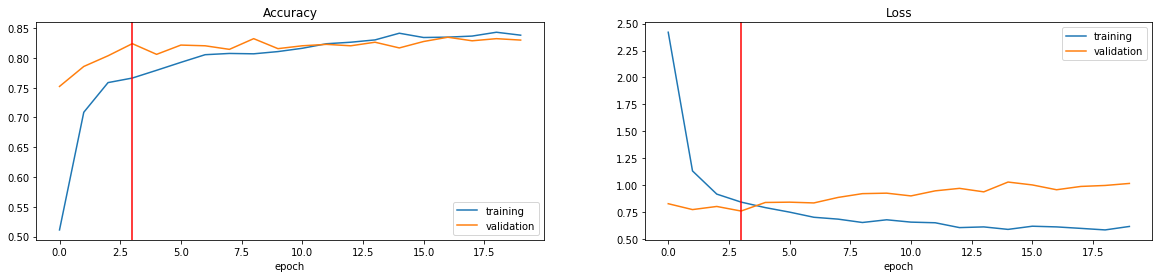

In [8]:
vis_learning_curve(training)

### Model evaluation: Test accuracy

In [15]:
test_tensors = [preprocess_input(t) for t in paths_to_tensor(test_files).astype('float32')]

100%|██████████| 836/836 [00:06<00:00, 128.33it/s]


In [18]:
model.load_weights('weights.best.Xception_with_data_augmentation.hdf5')
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_tensors]

test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.4593%
